In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

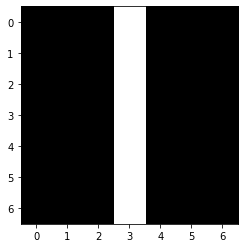

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 
filters[3, :, :, 1] = 1  
plt.imshow(filters[:,:,0,0], cmap='gray')
plt.show()

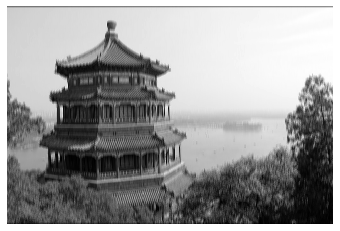

In [4]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 0], cmap="gray") 
plt.axis("off") 
plt.show()

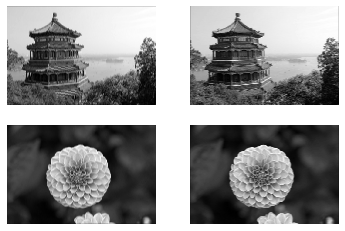

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

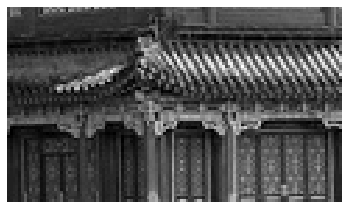

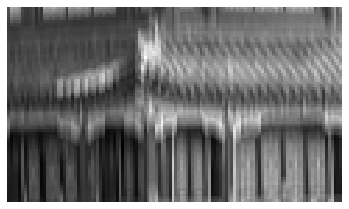

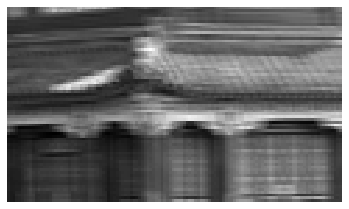

In [7]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

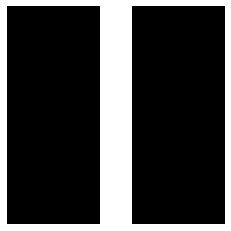

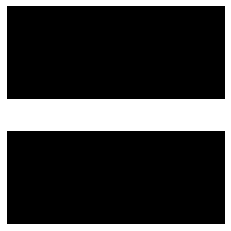

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [9]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

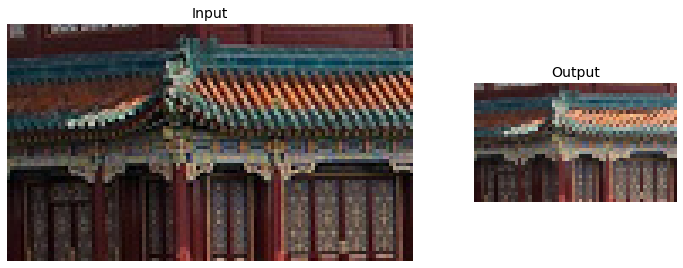

In [10]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) 
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0]) 
ax2.axis("off")
plt.show()

In [11]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [12]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): 
    depth_output = depth_pool(cropped_images)
cropped_images.shape, depth_output.shape

((2, 70, 120, 3), TensorShape([2, 70, 120, 1]))

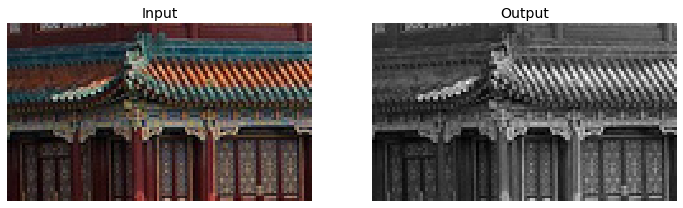

In [13]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0]) 
plt.axis("off")
plt.show()

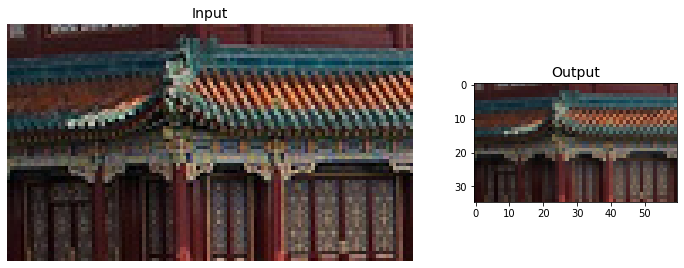

In [14]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0]) 
plt.show()

In [15]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=60, shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [16]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=63, shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [17]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [19]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
X_new = X_test[:10] 
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.2601 - accuracy: 0.9140 - val_loss: 0.2706 - val_accuracy: 0.9056
Epoch 2/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2429 - accuracy: 0.9173 - val_loss: 0.2897 - val_accuracy: 0.8974
Epoch 3/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2375 - accuracy: 0.9186 - val_loss: 0.2931 - val_accuracy: 0.9016
Epoch 4/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2312 - accuracy: 0.9203 - val_loss: 0.3188 - val_accuracy: 0.9032
Epoch 5/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2240 - accuracy: 0.9238 - val_loss: 0.3373 - val_accuracy: 0.9056


# ResNet-34

In [31]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                       padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()         
        ]
        self.skip_layers=[]
        if strides>1:
            self.skip_layers=[
                DefaultConv2D(filters,kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z=inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [32]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides=1 if prev_filters==filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))   

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_6 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_7 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_8 (ResidualUni (None, 56, 56, 64)       

In [37]:
model = keras.applications.resnet.ResNet34(weights="imagenet")

AttributeError: module 'tensorflow_core.keras.applications.resnet' has no attribute 'ResNet34'

['ResNet50',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'decode_predictions',
 'preprocess_input']

In [53]:
a = tf.random.uniform(shape=[1,2,2,2])
b = tf.random.normal(shape=[2,2,2])
tf.reduce_sum(b*a, axis=[1,2])

<tf.Tensor: id=102158, shape=(1, 2), dtype=float32, numpy=array([[-0.8237158,  1.5410928]], dtype=float32)>

In [43]:
dir(tf.random)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'all_candidate_sampler',
 'categorical',
 'experimental',
 'fixed_unigram_candidate_sampler',
 'gamma',
 'learned_unigram_candidate_sampler',
 'log_uniform_candidate_sampler',
 'normal',
 'poisson',
 'set_seed',
 'shuffle',
 'stateless_categorical',
 'stateless_normal',
 'stateless_truncated_normal',
 'stateless_uniform',
 'truncated_normal',
 'uniform',
 'uniform_candidate_sampler']